# Classification with FNO
Train an FNO timeseries classifier on handcrafted signals with noise as a proof of concept of using an FNO as a classifier.

In [1]:
import importlib
import model_utils
import data_utils
importlib.reload(model_utils)
importlib.reload(data_utils)
from model_utils import FNOClassifier
from data_utils import CustomDataset, RandomSample, RandomTimeTranslateFill05, RandomTimeTranslateReflect, RandomNoise

import os
import optuna
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

import pytorch_lightning as pl
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
pl.__version__

'2.1.3'

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available on device {torch.cuda.get_device_name(0)} with device count: {torch.cuda.device_count()}")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available on device NVIDIA GeForce RTX 2080 Ti with device count: 1


## Create a dataset

### Original way of generating data: x_train

In [15]:
# Define a function to generate the signals
def generate_signal(start, freqs=[1,0.01,0.1,0.005], noise_std=0.3, class_label=0, time_dim=500):
    # Generate the signal
    if class_label == 0:
        signal = np.sin(2 * np.pi * freqs[0] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[1] * np.arange(start, start+time_dim, 1))
    else:
        signal = np.sin(2 * np.pi * freqs[2] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[3] * np.arange(start, start+time_dim, 1))

    # Add noise to the signals
    noise = np.random.normal(0, noise_std, time_dim)
    signal += noise

    return signal

# Define a function to reshape, canonacalize, and normalize the signal
def preprocess_signal(signal):
    # Reshape the signal
    signal = signal.reshape((1, len(signal)))

    # Normalize the signal
    signal = (signal - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)

    # Canonicalize the data (pass through 0 at the origin)
    signal -= signal[:, 0].reshape(1, 1)

    return signal

# Generate a dataset c consisting of signals, equally split. y should contain label 0 for class 0 and label 1 for class 1
GLOBAL_MAX = 1.5
GLOBAL_MIN = -1.5
num_examples = 300
time_dim = 100
x = []
y = []

for i in range(num_examples):
    # If we are over halfway through num_samples, set label = 1
    if i < int(num_examples/2): 
        label = 0
    else: 
        label = 1

    # Generate the signal
    start = np.random.randint(0, num_examples)
    signal = generate_signal(start=start, class_label=label, time_dim=time_dim, noise_std=0)
    
    # Preprocess the signal
    signal = preprocess_signal(signal)

    # Append the signal to the data
    x.append(signal)
    y.append(label)

x = np.array(x)
y = np.array(y)

In [ ]:
# Create a list of indices for your dataset.
indices = list(range(len(x)))
np.random.shuffle(indices)

# Split the indices into three parts: train, val, and test
train_size = int(0.7 * len(x))
val_size = int(0.2 * len(x))
test_size = len(x) - train_size - val_size

train_indices, val_indices, test_indices = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

# Create datasets
x_train = torch.tensor(x[train_indices], dtype=torch.float32)
y_train = torch.tensor(y[train_indices], dtype=torch.float32)
x_val = torch.tensor(x[val_indices], dtype=torch.float32)
y_val = torch.tensor(y[val_indices], dtype=torch.float32)
x_test = torch.tensor(x[test_indices], dtype=torch.float32)
y_test = torch.tensor(y[test_indices], dtype=torch.float32)

# Print the size and ratio of classes in train, validation, and test set
print("Train set shape: ", x_train.shape, "Train set ratio of class 0 to total: ", np.sum(y[train_indices] == 0)/len(train_indices))
print("Validation set shape: ", x_val.shape, "Validation set ratio of class 0 to total: ", np.sum(y[val_indices] == 0)/len(val_indices))
print("Test set shape: ", x_test.shape, "Test set ratio of class 0 to total: ", np.sum(y[test_indices] == 0)/len(test_indices))

## Create dataloader

In [17]:
# Create train, valid, and test data loaders
batch_size = 16 # too large of a batchsize crashes the kernel (memory issues due to fft and irfft)
workers = 0
data_augmentation = None
seq_length = time_dim

train_loader = DataLoader(
        CustomDataset(
                x_train,
                y_train,
                transform = data_augmentation  
        ),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=workers, 
)  

valid_loader = DataLoader(
        CustomDataset(
                x_val,
                y_val,
                transform = None
        ),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        num_workers=workers,
)

test_loader = DataLoader(
        CustomDataset(
                x_test,
                y_test,
                transform = None
        ),
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
        num_workers=workers,
)

# Print the size of a batch and type of data
for x, y in train_loader:
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    print("Sample batch of labels: " + str(y.shape))
    break

# Print number of batches in train and validation set
print(f"Number of batches in train set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(valid_loader)}")

Sample batch of data (batch size, # channels, sequence length): torch.Size([16, 1, 100])
Sample batch of labels: torch.Size([16])
Number of batches in train set: 13
Number of batches in validation set: 3


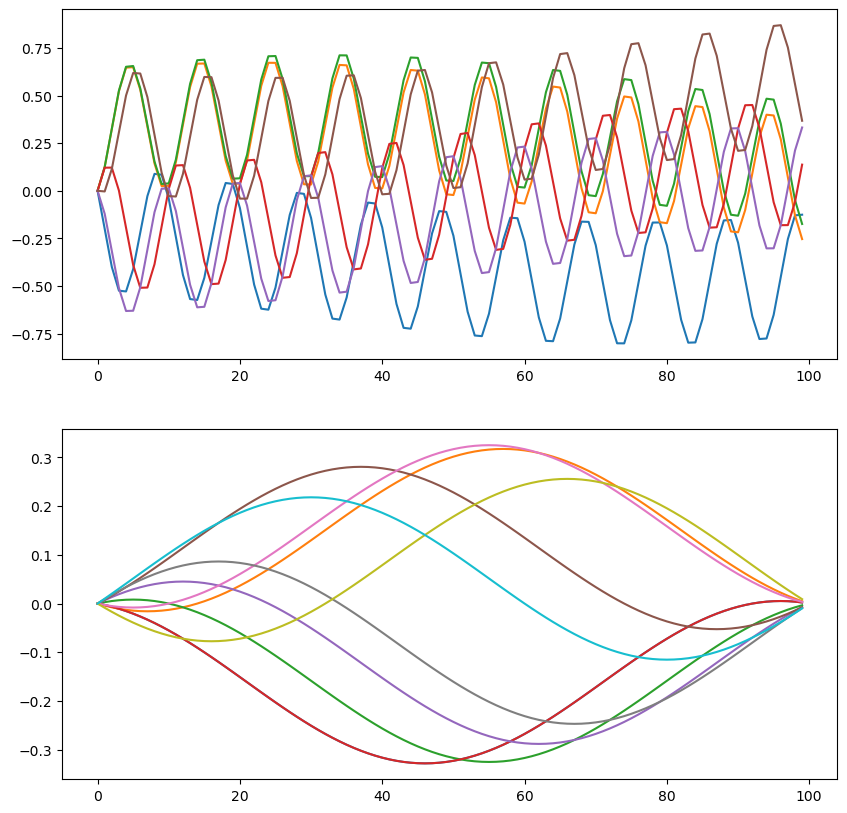

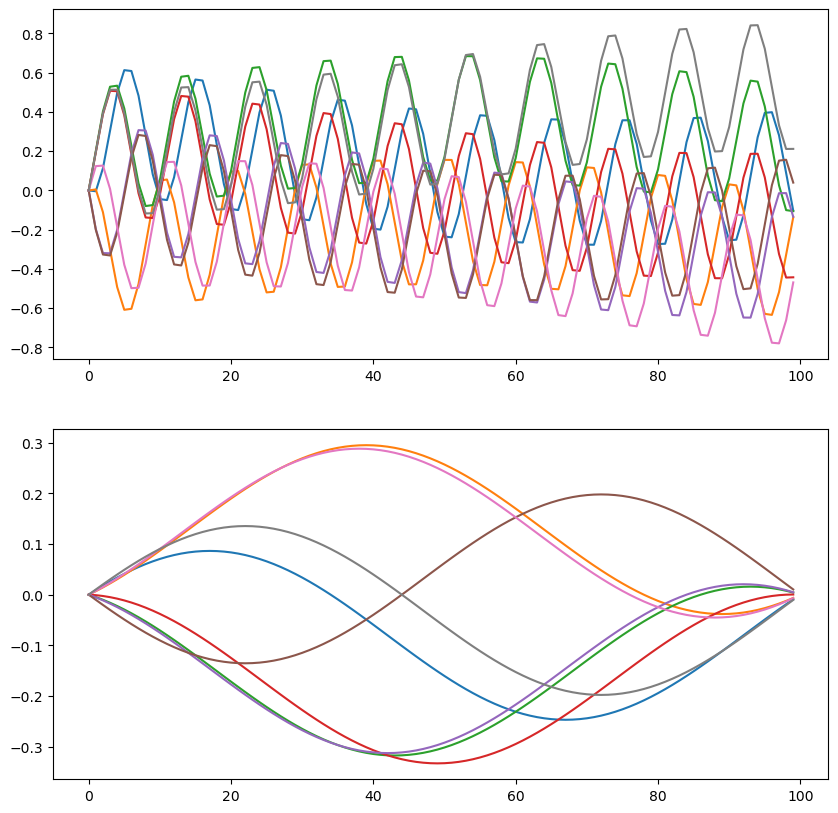

In [18]:
# Plot a few signals from train_loader
# Plot in different 2 subplots: top if label == 1, bottom if label == 0
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(train_loader):
    if i == 1:
        break
    for j in range(x.shape[0]):
        if y[j] == 1:
            plt.subplot(2, 1, 1)
            plt.plot(x[j, 0, :])
        else:
            plt.subplot(2, 1, 2)
            plt.plot(x[j, 0, :])
plt.show()

# Plot a few signals from train_loader
# Plot in different 2 subplots: top if label == 1, bottom if label == 0
plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(valid_loader):
    if i == 1:
        break
    for j in range(x.shape[0]):
        if y[j] == 1:
            plt.subplot(2, 1, 1)
            plt.plot(x[j, 0, :])
        else:
            plt.subplot(2, 1, 2)
            plt.plot(x[j, 0, :])
plt.show()

## Train and test a model

In [19]:
# Hyperparameters
modes = 6
channels = [256, 128, 64, 32] # Note: if last channel is too big, final fc layer takes over and model collapses
pool_type = "avg" 
pooling = seq_length # Remember to change this if using RandomSample augmentation
proj_dim = 32 # Dimension to project to initially
p_dropout = 0.5
add_noise = False

# Optimizers and learning rate schedulers
# lr schedule options are reducelronplateau, steplr, exponentiallr, cosineannealinglr, and cosineannealingwarmrestarts
# optimizer options are sgd or adam
optimizer = "adam"
momentum = 0 # Only used for SGD optimizer
scheduler = "reducelronplateau"
lr = 1e-2

# Initialize classifier
classifier = FNOClassifier(
                modes=modes, 
                lr=lr, 
                channels=channels, 
                pooling=pooling, 
                optimizer=optimizer, 
                scheduler=scheduler, 
                momentum=momentum, 
                pool_type=pool_type, 
                seq_length=seq_length,
                proj_dim=proj_dim,
                p_dropout=p_dropout, 
                add_noise=add_noise
)

# Print the model
print(classifier)

FNOClassifier(
  (loss): BCELoss()
  (project): Sequential(
    (0): Linear(in_features=100, out_features=3200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (fno_layer_0): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([32, 256, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_1): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([256, 128, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_2): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([128, 64, 4]), rank=None)
      )
    )
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_3): Sequential(
    (0): S

In [20]:
# Create a tensorboard logger
experiment_name = "signal_dataset_second_pass"
save_directory = "../logs/"

# Check if save_dir/experiment_name exists, if not create it
if not os.path.exists(save_directory + experiment_name):
    os.makedirs(save_directory + experiment_name)

logger = TensorBoardLogger(save_dir=save_directory, name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
logger.log_hyperparams({
    "modes": modes, 
    "lr": lr, 
    "proj_dim": proj_dim,
    "channels": channels,
    "pool_type": pool_type, 
    "pooling": pooling, 
    "lr_scheduler": scheduler, 
    "batchsize": batch_size, 
    "optimizer": optimizer, 
    "momentum": momentum,
    "p_dropout": p_dropout,
    "add_noise": add_noise,
    "data_augmentation": data_augmentation,
    "neuralop_or_mine": "neuralop_package"
})
print("Tensorboard logs will be saved to: " + logger.log_dir)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, mode="min"),
    LearningRateMonitor(logging_interval="step"),
]

# Train the model
trainer = Trainer(max_epochs=100,
                  logger=logger,
                  callbacks=callbacks,
                  accelerator="auto"
)

trainer.fit(model=classifier, 
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
)

Tensorboard logs will be saved to: ../logs/signal_dataset_second_pass/2024_04_26-18_35_13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | In sizes      | Out sizes    
-------------------------------------------------------------------------------
0 | loss            | BCELoss    | 0      | ?             | ?            
1 | project         | Sequential | 323 K  | [1, 1, 100]   | [1, 1, 3200] 
2 | fno_layer_0     | Sequential | 66.3 K | [1, 32, 100]  | [1, 256, 100]
3 | fno_layer_1     | Sequential | 262 K  | [1, 256, 100] | [1, 128, 100]
4 | fno_layer_2     | Sequential | 65.7 K | [1, 128, 100] | [1, 64, 100] 
5 | fno_layer_3     | Sequential | 16.5 K | [1, 64, 100]  | [1, 32, 100] 
6 | dropout         | Dropout    | 0      | [1, 32]       | [1, 32]      
7 | fc_post_dropout | Linear     | 33     | [1, 32]       | [1, 1]       
8 | pool            | AvgPool1d  | 0      | [1, 32, 100]  |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [21]:
# Test the model
trainer.test(dataloaders=test_loader)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ../logs/signal_dataset_second_pass/2024_04_26-18_35_13/checkpoints/epoch=99-step=1300.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/signal_dataset_second_pass/2024_04_26-18_35_13/checkpoints/epoch=99-step=1300.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.006515576969832182    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.006515576969832182, 'test_acc': 1.0}]

Accuracy: 1.0


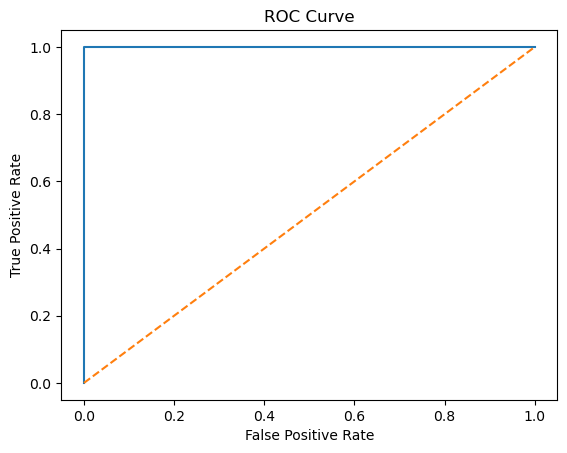

In [22]:
classifier.eval()

# Get the true labels and predicted probabilities
y_true = np.zeros(0)
y_pred_probs = np.zeros(0)

for x, y in test_loader:
    y_true = np.concatenate((y_true, y.flatten().numpy()))
    y_pred = classifier.forward(x).detach().numpy()
    y_pred_probs = np.concatenate((y_pred_probs, y_pred[:]))

# Calculate accuracy
binary_y_pred = np.where(y_pred_probs > 0.5, 1, 0)
accuracy = np.sum(binary_y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy}")

# Calculate the FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()